In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate

In [3]:
# given properties
weight = 2400 * 4.44822
drag_coeff_0 = 0.0317
aspect_ratio = 5.71
oswald_eff = 0.6
lift_coeff_max = 1.45
brake_hp = 180

# found properties
max_velocity = 60.7044

density_SL = 1.225
area = 170 * 0.092903

density_5 = 1.055
density_10 = 0.9093
density_15 = 0.7779

density = np.array([density_SL, density_5, density_10, density_15])
sigmas = np.array([rho / density_SL for rho in density])

In [4]:
# finding lift and velocity ranges
lift_coeff_min = (2 * weight) / (density_SL * area * max_velocity**2)
lift_coeff = np.linspace(lift_coeff_min, lift_coeff_max, 100)

stall_velocity = np.sqrt((2 * weight) / (density_SL * area * lift_coeff_max))
velocity = np.linspace(stall_velocity, max_velocity, 100)

velocity = np.array([velocity * np.sqrt(sigma) for sigma in sigmas])

In [5]:
# finding drag
drag_coeff = np.array([drag_coeff_0 + np.power(cl, 2) / (np.pi * aspect_ratio * oswald_eff) for cl in lift_coeff])

drag = [
    [0.5 * rho * np.power(velocity[i][j], 2) * area * drag_coeff[j] for j in range(len(velocity[i]))] for i, rho in enumerate(density)
]
drag = np.array(drag)

In [6]:
# finding power required
# power_req = np.array([[drag[i][j] * velocity[i][j] for j in range(len(drag[i]))] for i in range(len(densities))])
power_required = drag * velocity # numpy arrays are blessed

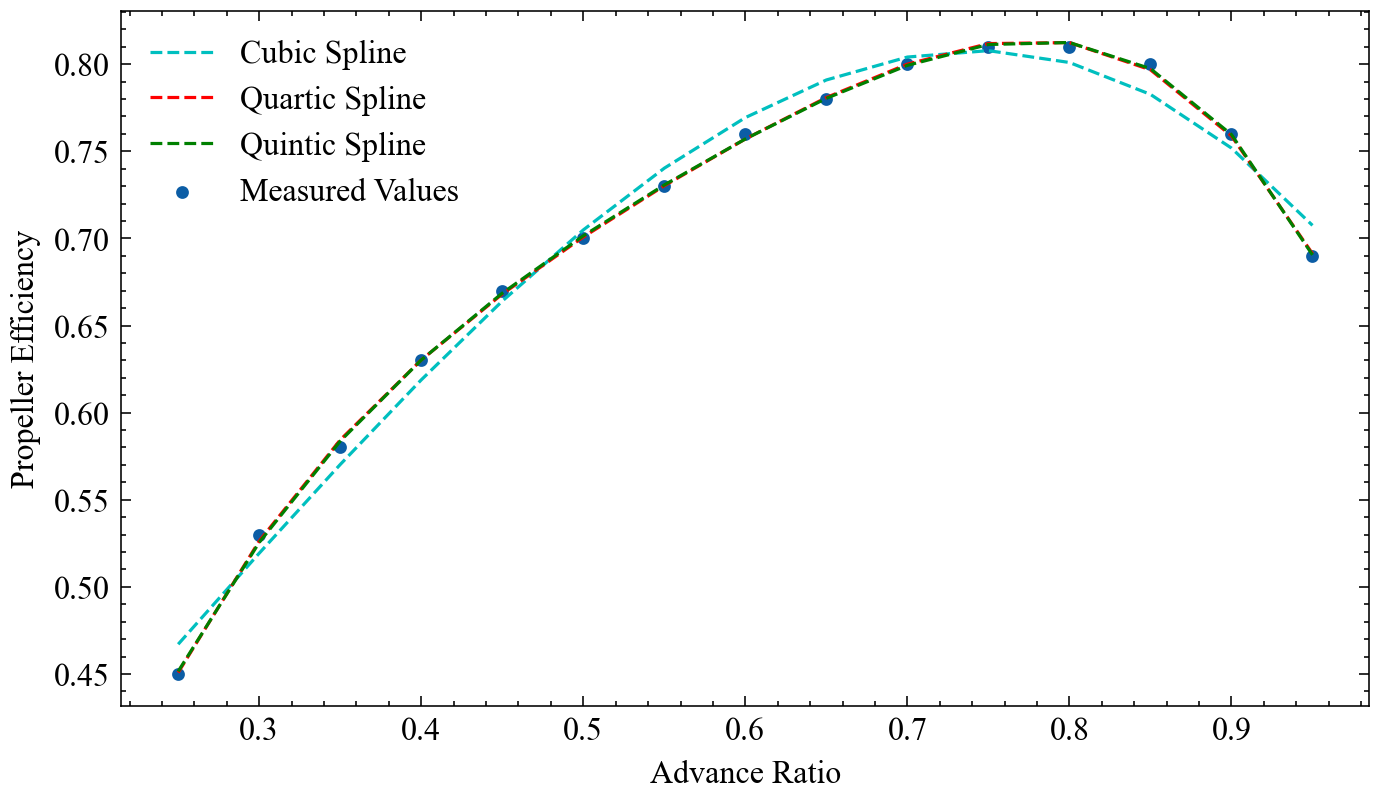

In [7]:
# finding propeller efficiency
adv_ratio = np.linspace(0.25, 0.95, 15)
prop_eff = np.array([0.45, 0.53, 0.58, 0.63, 0.67, 0.70, 0.73, 0.76, 0.78, 0.80, 0.81, 0.81, 0.80, 0.76, 0.69])
prop_eff_interp_3 = interpolate.UnivariateSpline(adv_ratio, prop_eff)
prop_eff_interp_4 = interpolate.UnivariateSpline(adv_ratio, prop_eff, k=4)
prop_eff_interp_5 = interpolate.UnivariateSpline(adv_ratio, prop_eff, k=5)

plt.figure(dpi=230, figsize=(7,4))
plt.style.use(['science', 'no-latex'])

plt.scatter(adv_ratio, prop_eff, marker='.', label='Measured Values')
plt.plot(adv_ratio, prop_eff_interp_3(adv_ratio), color='c', linestyle='--', label='Cubic Spline')
plt.plot(adv_ratio, prop_eff_interp_4(adv_ratio), color='r', linestyle='--', label='Quartic Spline')
plt.plot(adv_ratio, prop_eff_interp_5(adv_ratio), color='g', linestyle='--', label='Quintic Spline')

plt.xlabel('Advance Ratio')
plt.ylabel('Propeller Efficiency')
plt.legend()

plt.show()

$$\displaystyle P_\text{available} = \eta \; \text{BHP} \; \sigma^{0.7}$$

Where BHP is the rated brake horsepower. Efficiency, eta, as given in the supplied graph depends on the propeller RPS, n, and diameter, D. If you are only interested in the maximum power available, it is fairly easy to just use the maximum rated RPM of the propeller (note, n is RPS). Otherwise, if you want to know what your power required for level and steady flight is, you need to iterate, since n has to be adjusted in order to get adequate power.

In [8]:
# finding power available
prop_rot = 2700 * 0.016667
prop_diameter = 73 * 0.0254
advance_ratios = velocity / (prop_rot * prop_diameter)

power_available = np.array([
    [prop_eff_interp_4(j) * (brake_hp * 745.7) * np.power(sigmas[i], 0.7) for j in advance_ratios[i]] for i in range(len(sigmas))
])

In [11]:
# find maximum rate of climb
#climb_rate = np.array([power_available[i]/weight - np.sqrt(2*weight/density[i]*area) * np.sqrt(np.power(drag_coeff, 2)/np.power(lift_coeff, 3)) for i in range(len(density))])
climb_rate = (power_available - power_required)/weight

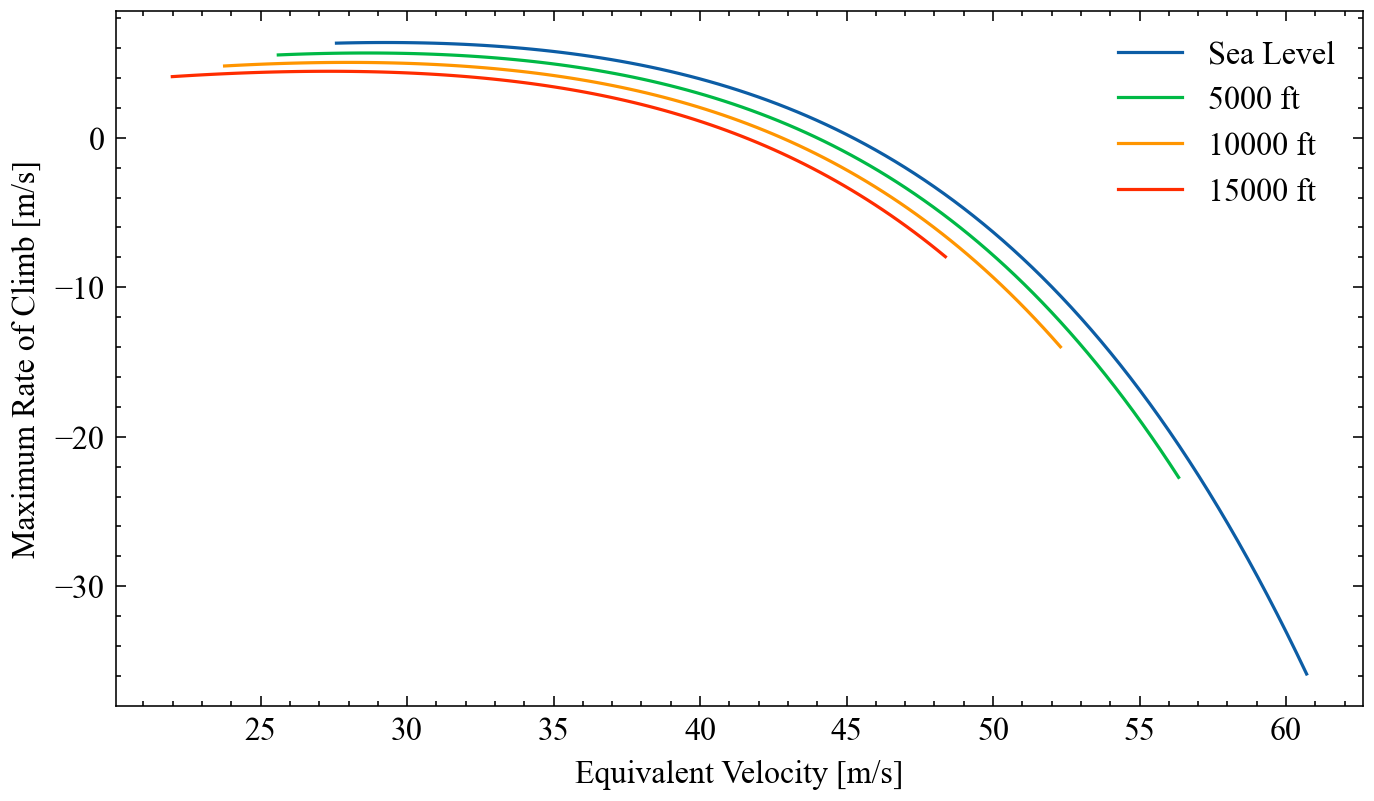

In [20]:
plt.figure(dpi=230, figsize=(7,4))
plt.style.use(['science', 'no-latex'])

plt.plot(velocity[0], climb_rate[0], label='Sea Level')
plt.plot(velocity[1], climb_rate[1], label='5000 ft')
plt.plot(velocity[2], climb_rate[2], label='10000 ft')
plt.plot(velocity[3], climb_rate[3], label='15000 ft')

plt.xlabel('Equivalent Velocity [m/s]')
plt.ylabel('Maximum Rate of Climb [m/s]')
plt.legend()

plt.show()